In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

%load_ext autoreload
%autoreload 2

In [2]:
from crawler import async_cache_pages, urls_list

In [3]:
# edX does not work as some content seems to be dynamically downloaded
folders = ["coursera", "general"]

positives, negatives = urls_list(folders)
async_cache_pages(positives + negatives)

Error while downloading: https://about.udemy.com/blog/?ref=footer. Status code: 403
Error while downloading: https://business.udemy.com/?ref=ufb_header. Status code: 403
Error while downloading: https://www.amazon.com/Low-Price-With-Free-Shipping/. Status code: 404
Error while downloading: https://www.amazon.com/. Status code: 503
Error while downloading: https://about.udemy.com/careers/. Status code: 403
Error while downloading: http://blog.openclassrooms.com/en/. Status code: 403
Trying again to download 0 pages one at a time


In [4]:
feature_functions = {
        #"url": url,
        #"label": label,
        "a_count": lambda soup: len(soup.find_all("a")),
        "iframe_count": lambda soup: len(soup.find_all("iframe")),
        "h1_count": lambda soup: len(soup.find_all("h1")),
        "h2_count": lambda soup: len(soup.find_all("h2")),
        "h3_count": lambda soup: len(soup.find_all("h3")),
        "video_count": lambda soup: len(soup.find_all("video")),
        "button_count": lambda soup: len(soup.find_all("button"))
        
    }

In [5]:
from bs4 import BeautifulSoup
from crawler import get_cached, is_cached

def construct_df_features(urls, labels, features):
    row_list = []
    features_func = [feature_functions[feat] for feat in features]
    columns = ["url", "label"] + features

    for url, label in zip(urls, labels):
        if is_cached(url):
            soup = BeautifulSoup(get_cached(url), "lxml")

        row = [url, label] + [func(soup) for func in features_func]

        row_list.append(row)

    df = pd.DataFrame(row_list, columns=columns)
    df = df.set_index("url")
    
    return df

In [6]:
urls = [positives[0], negatives[0]]
labels = [True, False]
features = ["button_count", "a_count"]

construct_df_features(urls, labels, features)

,label,button_count,a_count
url,,,
https://www.coursera.org/learn/fashion-design,True,19,58
https://www.coursera.org/,False,5,104


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [8]:
all_features = sorted(list(feature_functions.keys()))

In [9]:
def cross_val(df, selected_features, estimator=RandomForestClassifier(), cv=3):
    X = df[selected_features]
    y = df["label"]
    
    return cross_val_score(estimator, X, y, cv=cv)

In [10]:
urls_pos, urls_neg = urls_list(["coursera", "general"])
urls = urls_pos + urls_neg
labels = [True] * len(urls_pos) + [False] * len(urls_neg)

results_means = []
results_stds = []

df = construct_df_features(urls, labels, all_features)

# iterate over all features and train on this feature alone
for feature in all_features:
    # Cross val with the selected feature alone
    scores = cross_val(df, [feature])
    
    results_means.append(np.mean(scores))
    results_stds.append(np.std(scores))

In [11]:
# Same thing, but with same ratio of positive and negative examples

import random
random.seed(0)

urls_pos, urls_neg = urls_list(["coursera", "general"])

# Same number of negative and positive examples
urls = urls_pos + random.sample(urls_neg, len(urls_pos))
labels = [True] * len(urls_pos) + [False] * len(urls_pos)

results_unbiased_means = []
results_unbiased_stds = []

df_unbiased = construct_df_features(urls, labels, all_features)

# iterate over all features and train on one feature alone
for feature in all_features:
    # Cross val with the selected feature alone
    scores = cross_val(df_unbiased, [feature])
    
    results_unbiased_means.append(np.mean(scores))
    results_unbiased_stds.append(np.std(scores))

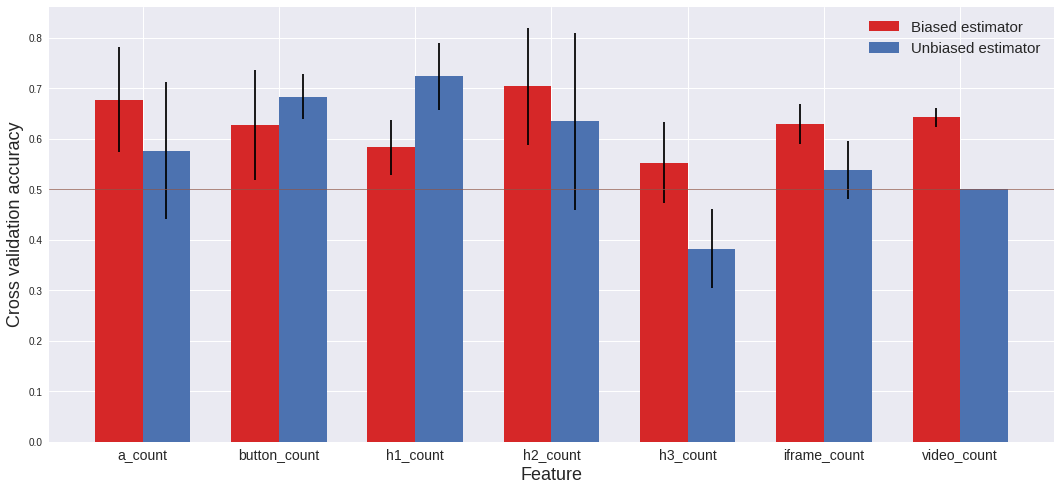

In [12]:
import os

index = np.arange(len(results_means))
fig, ax = plt.subplots(figsize=(18, 8))
bar_width = 0.35
axis_font_size = 18

plt.bar(index, results_means, bar_width, yerr=results_stds, color='tab:red', label="Biased estimator")
plt.bar(index + bar_width, results_unbiased_means, bar_width, yerr=results_unbiased_stds, label="Unbiased estimator")

plt.xlabel("Feature", fontsize=axis_font_size)
plt.ylabel("Cross validation accuracy", fontsize=axis_font_size)
plt.xticks(index + bar_width / 2, all_features, fontsize=14)

plt.axhline(y=0.5, color='tab:brown', alpha=0.7, linewidth=1)
plt.legend(fontsize=15)

plt.savefig(os.path.join("figures", "feature_score_biased_unbiased_acc"))

In [13]:
rf = RandomForestClassifier()

X = df_unbiased.drop("label", axis=1)
y = df_unbiased["label"]

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

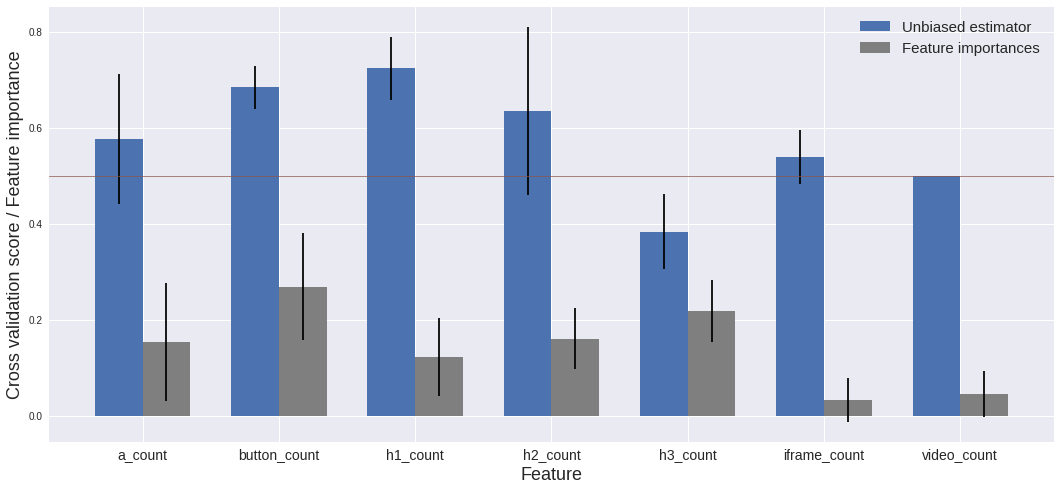

In [14]:
feature_importances = rf.feature_importances_
feature_importances_stds = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

index = np.arange(len(results_means))
fig, ax = plt.subplots(figsize=(18, 8))
bar_width = 0.35
axis_font_size = 18

plt.bar(index, results_unbiased_means, bar_width, yerr=results_unbiased_stds, label="Unbiased estimator")
plt.bar(index + bar_width, feature_importances, bar_width, color='tab:gray', yerr=feature_importances_stds, label="Feature importances")

plt.xlabel("Feature", fontsize=axis_font_size)
plt.ylabel("Cross validation score / Feature importance", fontsize=axis_font_size)
plt.xticks(index + bar_width / 2, all_features, fontsize=14)

plt.axhline(y=0.5, color='tab:brown', alpha=0.7, linewidth=1)
plt.legend(fontsize=15)

plt.savefig(os.path.join("figures", "feature_importance_and_feature_score"))

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
def training_score(df, selected_features, estimator=RandomForestClassifier()):
    X = df[selected_features]
    y = df["label"]
    
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    
    return accuracy_score(y, y_pred)

In [17]:
good_features = ["a_count", "button_count", "h1_count", "h2_count", "h3_count"]

In [18]:
n_estims_list = range(1, 21)
score_means = []
score_stds = []
train_scores = []
features = good_features

for n_estims in n_estims_list:
    scores = cross_val(df_unbiased, features, estimator=RandomForestClassifier(n_estimators=n_estims))
    
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
    train_score = training_score(df_unbiased, features, estimator=RandomForestClassifier(n_estimators=n_estims))
    train_scores.append(train_score)

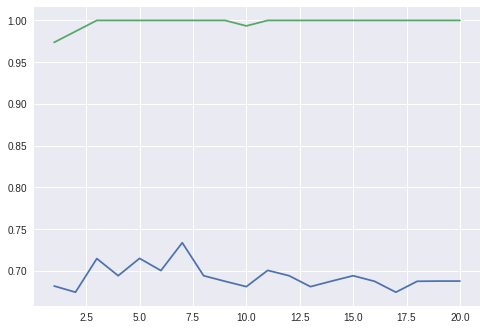

In [19]:
# No apparent overfitting (?)
plt.plot(n_estims_list, score_means)
plt.plot(n_estims_list, train_scores)

SVM is not supposed to work well, because ". SVMs do not perform well on highly skewed/imbalanced data sets. These are training data sets in which the number of samples that fall in one of the classes far outnumber those that are a member of the other class. Customer churn data sets are typically in this group because when you collect the training set, among a million customers during a particular time period, there would be very few who have actually churned. SMOTING is used to generate artificial samples in the minority class to balance the data set. On the other hand, Logistic Regression is good at handling skewed data sets."

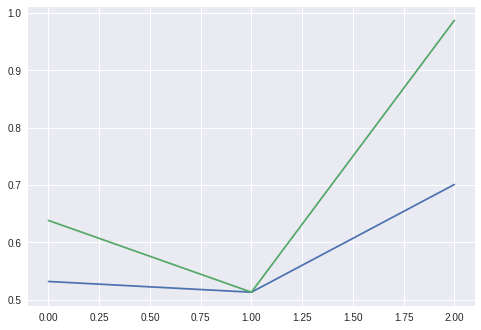

In [20]:
from sklearn import svm

kernels = ['linear', 'sigmoid', 'rbf']
score_means = []
score_stds = []
train_scores = []
features = good_features

for kernel in kernels:
    scores = cross_val(df_unbiased, features, estimator=svm.SVC(kernel=kernel))
    
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
    train_score = training_score(df_unbiased, features, estimator=svm.SVC(kernel=kernel))
    train_scores.append(train_score)
    
plt.plot(score_means)
plt.plot(train_scores)

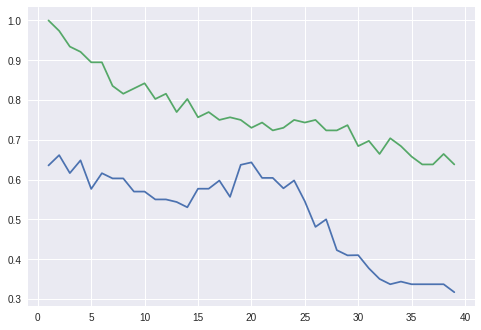

In [21]:
from sklearn.neighbors import KNeighborsClassifier

n_neigbours = range(1, 40)
score_means = []
score_stds = []
train_scores = []
features = good_features

for n in n_neigbours:
    scores = cross_val(df_unbiased, features, estimator=KNeighborsClassifier(n_neighbors=n))
    
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
    train_score = training_score(df_unbiased, features, estimator=KNeighborsClassifier(n_neighbors=n))
    train_scores.append(train_score)
    
plt.plot(n_neigbours, score_means)
plt.plot(n_neigbours, train_scores)

/home/tim/anaconda3/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


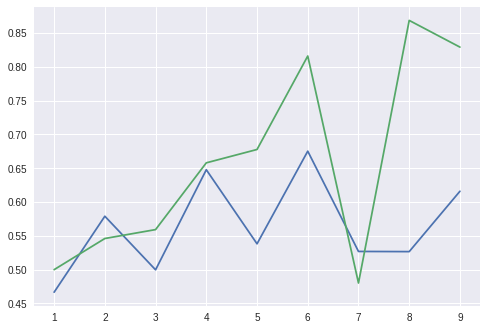

In [22]:
from sklearn.neural_network import MLPClassifier

layers = range(1, 10)
score_means = []
score_stds = []
train_scores = []
features = good_features

for layer in layers:
    scores = cross_val(df_unbiased, features, estimator=MLPClassifier(hidden_layer_sizes=(30,)*layer, random_state=1))
    
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
    train_score = training_score(df_unbiased, features, estimator=MLPClassifier(hidden_layer_sizes=(30,)*layer, random_state=1))
    train_scores.append(train_score)
    
plt.plot(layers, score_means)
plt.plot(layers, train_scores)

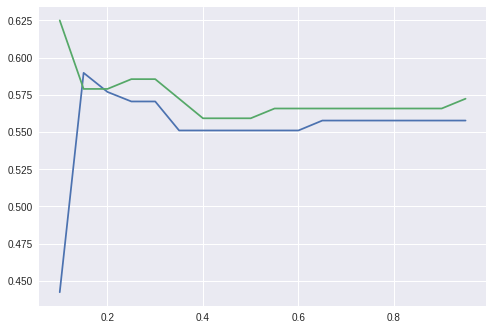

In [23]:
from sklearn.linear_model import LogisticRegression

reg_terms = np.arange(0.1, 1, 0.05)
score_means = []
score_stds = []
train_scores = []
features = good_features

for reg in reg_terms:
    scores = cross_val(df_unbiased, features, estimator=LogisticRegression(C=reg, random_state=1))
    
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
    train_score = training_score(df_unbiased, features, estimator=LogisticRegression(C=reg, random_state=1))
    train_scores.append(train_score)
    
plt.plot(reg_terms, score_means)
plt.plot(reg_terms, train_scores)

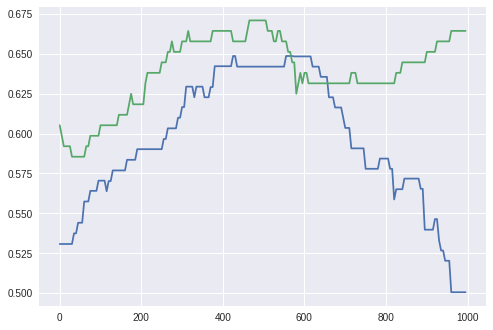

In [24]:
from sklearn.naive_bayes import MultinomialNB

alphas = np.arange(0.1, 1000, 5)
score_means = []
score_stds = []
train_scores = []
features = good_features

for alpha in alphas:
    scores = cross_val(df_unbiased, features, estimator=MultinomialNB(alpha=alpha))
    
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
    train_score = training_score(df_unbiased, features, estimator=MultinomialNB(alpha=alpha))
    train_scores.append(train_score)
    
plt.plot(alphas, score_means)
plt.plot(alphas, train_scores)